###Importing Modules:

In [2]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 67.2 MB/s eta 0:00:00


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datetime import datetime
from torch.optim.lr_scheduler import LambdaLR
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from google.colab import files
import csv
import pennylane

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


#Implementing the Classical Boltzmann Machine


###References:

Code: https://github.com/gvisen/credit-RBM-model/blob/main/RBM.py

Dataset: https://raw.githubusercontent.com/gvisen/credit-RBM-model/refs/heads/main/data/dataset.csv

Paper:https://arxiv.org/abs/2202.11060

##Creating the BM Class

Copied exactly from the GitHub profile: https://github.com/gvisen/credit-RBM-model/blob/main/RBM.py

Parameters:
        
        nv : int
            Number of visible units.
        nh : int
            Number of hidden units.
        k : int
            Number of steps in Gibbs sampling.
        dataset : (optional) torch Dataset object
            Dataset on which to train the model.
            Optionally needed before training to correctly initialize the visible bias to log(p/(1-p)) of
            mean activation probability of the visible units, which centers the
            model on the mean value of the visible units.
            If dataset is not passed, the visible bias is set to zero.
            If KDE is
        visible_normalized : bool
            True if visible units take values in [0,1], or
            False if visible units take values in {0,1}.
        lr : float
            Initial learning rate.
        lr_trend : str
            'linear' if learning rate linearly decreases each epoch
            from initial value `lr` to 0.
            'constant' if learning rate remains constant across epochs.
        bs : int
            Mini-batch size.
        epochs : int
            Number of epochs (i.e. iterations through whole dataset).
        print_step : int
            Number of epochs before next print message during training.
        verbose : bool
            Set to False if you don't want print messages during training.
        track_learning : bool
            True if learning during training should be tracked.
        track_step : int
            Number of epochs before next learning tracking.
      

In [ ]:
class RBM(nn.Module):
    """RBM implementation."""

    """
    Initialisation Routine - Sets up the model, training routine and hyperparameters
    """
    def __init__(self,
                 nv,
                 nh,
                 k=1,
                 training='CD',
                 dataset=None,
                 visible_normalized=False,
                 lr=0.001,
                 lr_trend='linear',
                 bs=1024,
                 epochs=100,
                 print_step=100,
                 verbose=True,
                 track_learning=False,
                 track_method='KDE',
                 track_step=100,
                 KDE_bandwidth=None):

        super(RBM, self).__init__()

        self.nv = nv # number of visible units
        self.nh = nh # number of hidden units

        self.lr = lr # learning rate
        self.lr_trend = lr_trend # learning rate trend
        self.bs = bs # batch size
        self.epochs = epochs
        self.print_step = print_step
        self.verbose = verbose
        self.track_learning = track_learning
        self.KDE_bandwidth = KDE_bandwidth
        self.rec_errors = []
        self.usedEpochs = []

        if isinstance(track_method, str):
            self.track_method = [track_method]
        elif isinstance(track_method, list):
            self.track_method = track_method
        else:
            raise ValueError('Track method must be string or list of strings')

        for track_method in self.track_method:
            if track_method not in ['KDE', 'MMD', 'NDB', 'rec_error']:
                raise ValueError('Unknown track method:', track_method)

        self.track_step = track_step
        self.learning_curve = {track_method: [] for track_method in self.track_method}

        # Whether value of visible units is activity (in [0,1]) or binary (in {0,1})
        self.visible_normalized = visible_normalized

        # Matrix initialized with a multidim normal
        self.W = torch.nn.Parameter(torch.normal(0, 0.01, size=(nh, nv)))
        # Visible bias

        self.bv = torch.nn.Parameter(torch.zeros((1, nv)))

        # Hidden bias
        self.bh = torch.nn.Parameter(torch.zeros((1, nh)))

        # step in CD-k
        self.k = k

        # Training method
        self.training = training

    def get_device(self):
        """Returns current device for model's parameter storage."""
        return next(self.parameters()).device

    def move_to_cuda(self):
        """Move model parameters to cuda, if available."""
        if torch.cuda.is_available():
            self.to('cuda')
        else:
            print('Cuda not available: model is being trained on CPU. May be slow.')

    def _hidden_prob(self, v, temp=1.):
        """Probability vector of hidden units given visible, i.e. P(H = 1|V)."""
        return torch.sigmoid(temp*F.linear(v, self.W, self.bh)).detach()

    def _visible_prob(self, h, temp=1.):
        """Probability vector of visible units given hidden, i.e. P(V = 1|H)."""
        return torch.sigmoid(temp*F.linear(h, self.W.t(), self.bv)).detach()

    def _sample_hidden(self, v):
        """Sample hidden units given visible"""
        prob = self._hidden_prob(v)
        return torch.bernoulli(prob)

    def _sample_visible(self, h):
        """Sample visible units given hidden."""
        prob = self._visible_prob(h)
        if self.visible_normalized:
            return prob
        else:
            return torch.bernoulli(prob)

    def free_energy(self, v):
        """Compute free energy, i.e. F(x) = -\log \sum_h \exp (-E(x, h))."""
        v_term = torch.matmul(v, self.bv.t())
        w_x_h = F.linear(v, self.W, self.bh)
        h_term = torch.sum(F.softplus(w_x_h), dim=1)
        return torch.mean(-h_term - v_term)

    def forward(self, v_initial, v_given=None, n_steps=None):
        """Perform Gibbs sampling.

        Parameters:
        -----------
        v_initial : torch.tensor
            Initial value of visible units.
        v_given : (optional) list (length = self.nv)
            Values of visible units to condition on. Set value to None
            if you don't want to condition on that unit.
        n_steps : int
            Number of steps in Gibbs sampling.

        Returns:
        --------
        v_gibbs : torch.tensor
            Value of visible units after Gibbs sampling.
        """

        if n_steps == None:
            n_steps = self.k

        h = self._sample_hidden(v_initial)

        if v_given is not None:
            v_given_indices = torch.nonzero(~torch.isnan(v_given), as_tuple=True)[1]
            v_given_values = v_given[torch.nonzero(~torch.isnan(v_given), as_tuple=True)]

        for _ in range(n_steps):

            v_gibbs = self._sample_visible(h)

            # conditional sampling if v_given not None
            if v_given is not None:
                v_gibbs[:, v_given_indices] = v_given_values

            h = self._sample_hidden(v_gibbs)

        return v_gibbs

    def fit(self, dataset):
        """Train model on dataset.

        Parameters:
        -----------
        dataset : torch Dataset object
            Training dataset.
        """

        # Move model to cuda if available.
        self.move_to_cuda()

        # Optimizer.
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)

        # Dataloader.
        # Attention: setting drop_last = False would raise error during PCD
        # training (last batch in `data` may have different size than last Gibbs
        # state in `v_gibbs` when batch_size `bs` is not a divisor of
        # number of samples in dataset.

        if dataset.__getitem__(torch.arange(len(dataset))).device.type == 'cuda':

            train_loader = DataLoader(dataset,
                                      batch_size=self.bs,
                                      shuffle=True,
                                      drop_last=True,
                                      pin_memory=False)
        else:
            print('Dataset is on CPU. Memory pinning activated.')
            print('If the dataset is not too big, consider moving it to GPU calling dataset.to("cuda")')
            dataset.to("cuda")
            train_loader = DataLoader(dataset,
                                      batch_size=self.bs,
                                      shuffle=True,
                                      drop_last=True,
                                      pin_memory=True)



        # Learning rate scheduler.
        if self.lr_trend == 'linear':
            lr_factor = lambda iep: 1. - iep/self.epochs
        elif self.lr_trend == 'constant':
            lr_factor = lambda iep: 1.
        else:
            print('Warning: unknown learning rate trend', self.lr_trend)
            print('Constant learning rate trend is assumed.')
            lr_factor = lambda iep: 1.
        scheduler = LambdaLR(optim, lr_lambda=lr_factor)

        v_gibbs = None
        for iep in range(self.epochs):

            loss = 0.
            rec_loss = 0.

            for iter_num, data in enumerate(train_loader):
                optim.zero_grad()

                data = data.to(self.get_device())
                data = data.float()

                # Implement PCD training
                if self.training == 'PCD' and v_gibbs is not None:
                    v_initial = v_gibbs
                else:
                    v_initial = data

                v_gibbs = self.forward(v_initial)
                loss_batch = self.free_energy(data) - self.free_energy(v_gibbs)

                loss_batch.backward()
                optim.step()

                loss = loss + float(loss_batch)/len(train_loader)
                rec_loss = rec_loss + float((v_initial - v_gibbs).norm(2, dim=1).mean()/len(train_loader))

            # Learning rate is updated according to scheduler
            scheduler.step()

            if iep % self.print_step == 0 and self.verbose:
                print("Epoch: {}, Loss: {}, Rec. error: {}".format(iep, loss, rec_loss))

            # Track (in-sample) learning.
            if self.track_learning and iep % self.track_step == 0:
                self.usedEpochs.append(iep)
                for track_method in self.track_method:
                    learning_estimate = self.get_insample_learning(dataset, track_method)
                    self.learning_curve[track_method].append(learning_estimate)
                    print(track_method, '=', learning_estimate)

    def saveModel(self, filename=None, pickle_protocol=None):
        """Save model in pt file."""

        if filename is None:
            timestamp = datetime.now().strftime("%d-%m-%Y_(%H:%M:%S)")
            filename = 'savepoint_' + timestamp + '.pt'

        if pickle_protocol is None:
            torch.save(self, filename)
        else:
            torch.save(self, filename, pickle_protocol = pickle_protocol)


    def check_overfit(self, train_data, val_data):
        """Returns the free energy differential between training dataset and validation
        dataset, which is used to monitor overfitting."""
        return self.free_energy(train_data) - self.free_energy(val_data)

    def sample(self, n_samples, v_given=None, therm=10**4):
        """Return sample from model.

        Parameters:
        -----------
        n_samples : int
            Number of samples.
        v_given : (optional) torch.tensor
            Values of visible units to condition on. Set value to nan
            if you don't want to condition on that unit.
        therm : int
            Number of steps in Gibbs sampling (a.k.a. thermalization).
            To obtain an iid sample the chain must have reached convergence, therefore
            it should be >= 10**3.
        """
        self.move_to_cuda()

        with torch.no_grad():
            if self.visible_normalized:
                random_init = torch.rand((n_samples,self.nv), dtype=torch.float).cuda()
            else:
                random_init = torch.randint(2,(n_samples,self.nv), dtype=torch.float).cuda()

            if v_given is not None:
                if not torch.is_tensor(v_given):
                    raise ValueError('v_given must be torch tensor.')
                v_gibbs = self.forward(random_init, v_given=v_given.to(self.get_device()), n_steps=therm)
            else:
                v_gibbs = self.forward(random_init, v_given=None, n_steps=therm)

        v_gibbs = v_gibbs.to('cpu')
        return v_gibbs

    def get_insample_learning(self, dataset, track_method):
        learning_estimate = self.get_reconstruction_error(dataset)
        return learning_estimate

    def get_reconstruction_error(self, dataset, n_samples=10000, therm=10**4):
        """Reconstruction error (L^2 norm) of RBM on a dataset.

        Average minimum L^2 norm distance of points in a dataset from
        a sample of the RBM.

        Parameters:
        -----------
        dataset : pytorch Dataset object
            Dataset to compute log-likelihood on.
        therm : int (default: 10**4)
            Thermalization parameter for RBM sampling.

        Returns:
        --------
        error : float
            Average reconstruction error.
        """

        # Generate sample from RBM
        sample = self.sample(n_samples, therm=therm).cpu().numpy()

        if len(dataset) > n_samples:
            data = dataset.__getitem__(np.random.choice(list(range(len(dataset))), size=n_samples, replace=False)).to('cpu')
        else:
            data = dataset.__getitem__(list(range(len(dataset)))).to('cpu') # get whole dataset


        if torch.is_tensor(data):
            errors = list(map(lambda datapoint: np.min(np.sum((sample - datapoint)**2, axis=1)), data.numpy()))
        elif isinstance(data, np.ndarray):
            errors = list(map(lambda datapoint: np.min(np.sum((sample - datapoint)**2, axis=1)), data))
        else:
            raise ValueError('The __getitem__() method of dataset argument ' +
                             'must return either a torch tensor, or a numpy ndarray.')
        error = np.mean(np.array(errors))
        self.rec_errors.append(error)
        return error

    def recPlot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.usedEpochs, self.rec_errors, marker='o', linestyle='-', color='b', label='Reconstruction Error')
        plt.yscale('log')
        plt.title('Epoch vs L2 Reconstruction Error')
        plt.xlabel('Epoch')
        plt.ylabel('L2 Reconstruction Error')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

##Importing the Dataset into PyTorch

In [3]:
dataset = files.upload()

Saving dataset.csv to dataset.csv


In [4]:
data_path = 'dataset.csv'
columnsToUse = (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30)
data_numpy = np.loadtxt(data_path, dtype=np.float64, delimiter=';', skiprows=1, usecols=columnsToUse)
training_data_numpy = data_numpy[:4189]
evaluation_data_numpy = data_numpy[4189:]

In [5]:
col_names = next(csv.reader(open(data_path), delimiter=';'))
del col_names[0]

dates = []
dataAsArray = list(csv.reader(open(data_path), delimiter=';'))
for line in dataAsArray:
  dates.append(line[0])
del dates[0]

training_dates=dates[:4189]
evaluation_dates = dates[4189:]

In [6]:
training_data_pytorch = torch.from_numpy(training_data_numpy)
evaluation_data_pytorch = torch.from_numpy(evaluation_data_numpy)

In [7]:
torch.set_printoptions(precision=12)
print(evaluation_data_pytorch)


tensor([[0.003514009932, 0.010080844481, 0.060034814404,  ...,
         0.044825033191, 0.000645744244, 0.040994558530],
        [0.003337483233, 0.010533563351, 0.060015460136,  ...,
         0.042234696350, 0.000620484259, 0.038383462101],
        [0.003291309129, 0.010652188734, 0.060814058451,  ...,
         0.042271291275, 0.000538204375, 0.038724898958],
        ...,
        [0.012029129217, 0.001100296357, 0.190992658793,  ...,
         0.057854031846, 0.006825160351, 0.087621650541],
        [0.012136197904, 0.001013145617, 0.186421119130,  ...,
         0.059609003923, 0.006548246179, 0.073548064339],
        [0.011690404161, 0.000947054753, 0.192125037940,  ...,
         0.058214050425, 0.006181127738, 0.077283366498]], dtype=torch.float64)


##Creating the Boltzmann Machine Object

##5 Hidden Nodes

Dataset is on CPU. Memory pinning activated.
If the dataset is not too big, consider moving it to GPU calling dataset.to("cuda")
Epoch: 0, Loss: -0.45418494939804077, Rec. error: 0.6605661455541849
rec_error = 5.262967559642398
Epoch: 100, Loss: -0.29861414432525635, Rec. error: 0.11159444972872734
rec_error = 0.24456143229603228
Epoch: 200, Loss: -0.3645486831665039, Rec. error: 0.21382469683885574
rec_error = 0.17790207399600513
Epoch: 300, Loss: -0.05208325386047363, Rec. error: 0.26440665125846863
rec_error = 0.1406473673480324
Epoch: 400, Loss: -0.036198973655700684, Rec. error: 0.31799060851335526
rec_error = 0.1248369731309453
Epoch: 500, Loss: -0.14181780815124512, Rec. error: 0.3195243626832962
rec_error = 0.11169799307070141
Epoch: 600, Loss: -0.1994946002960205, Rec. error: 0.3525215685367584
rec_error = 0.1053901575165741
Epoch: 700, Loss: 0.11691045761108398, Rec. error: 0.32635650783777237
rec_error = 0.10727657509010163
Epoch: 800, Loss: -0.1779475212097168, Rec. error: 

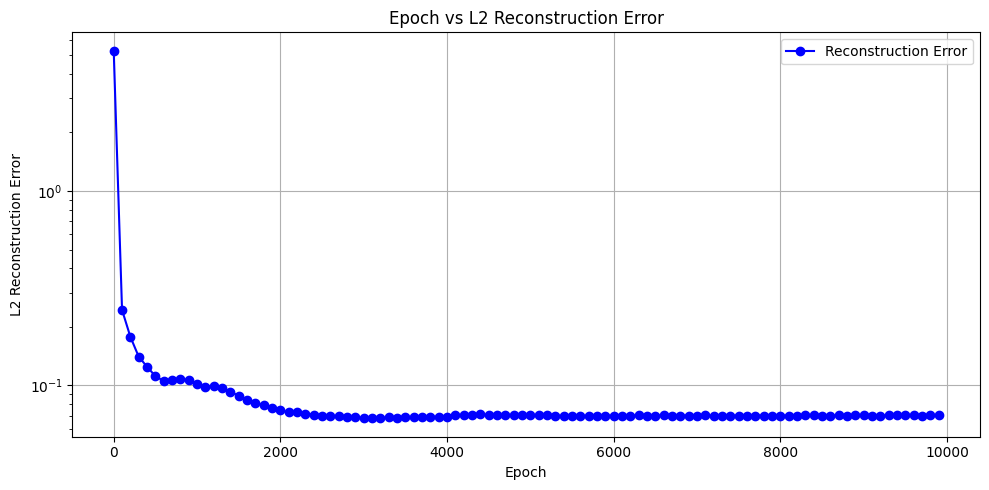

In [ ]:

dataset = training_data_pytorch
dataset.to('cuda')

# number of hidden units
nh = 5
# number of visible units
nv = 30

rbm5H = RBM(nv=nv,
          nh=nh,
          k=2,
          training='PCD',
          visible_normalized=True,
          lr=0.007,
          lr_trend='linear',
          bs=1000,
          epochs=10000,
          print_step=100,
          verbose=True,
          track_method=['rec_error'],
          track_learning=True,
          track_step = 100)

rbm5H.fit(dataset)
rbm5H.recPlot()

In [ ]:

with open('rbm5Hrecs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in rbm5H.rec_errors:
        writer.writerow([item])
    file.close()

with open('rbm5Hepochs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in rbm5H.usedEpochs:
        writer.writerow([item])
    file.close()

##10 Hidden Nodes

Dataset is on CPU. Memory pinning activated.
If the dataset is not too big, consider moving it to GPU calling dataset.to("cuda")
Epoch: 0, Loss: -0.7605888843536377, Rec. error: 0.6761959549039602
rec_error = 4.46718970203683
Epoch: 100, Loss: -0.12482666969299316, Rec. error: 0.1321004219353199
rec_error = 0.21364803859066797
Epoch: 200, Loss: -0.09341955184936523, Rec. error: 0.28845325112342834
rec_error = 0.13582242636198588
Epoch: 300, Loss: -0.09635257720947266, Rec. error: 0.3716277852654457
rec_error = 0.08683087909241519
Epoch: 400, Loss: -0.11647868156433105, Rec. error: 0.46949276328086853
rec_error = 0.0589697381263609
Epoch: 500, Loss: -0.0893394947052002, Rec. error: 0.48490652441978455
rec_error = 0.04734344573782295
Epoch: 600, Loss: -0.14072084426879883, Rec. error: 0.5030633211135864
rec_error = 0.043979146398591726
Epoch: 700, Loss: -0.10143852233886719, Rec. error: 0.5219885408878326
rec_error = 0.04295332323135065
Epoch: 800, Loss: -0.033002614974975586, Rec. error

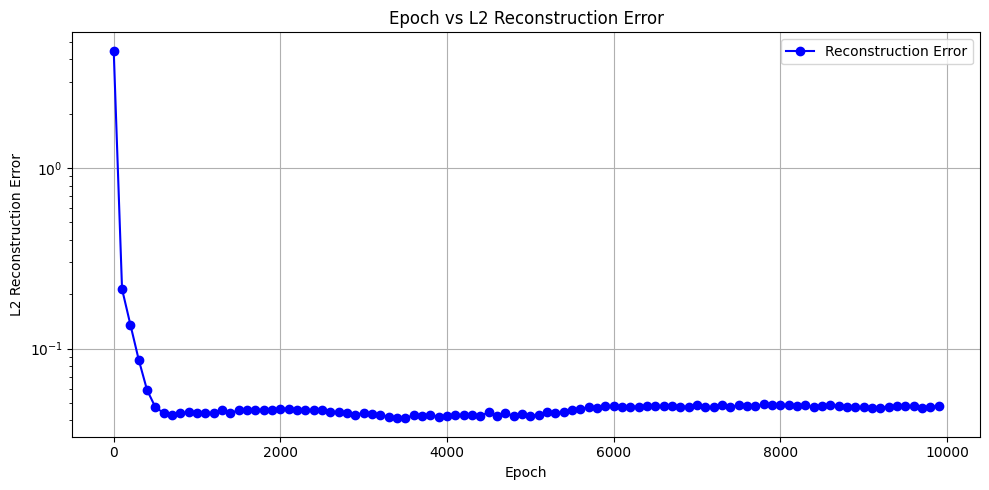

In [ ]:

dataset = training_data_pytorch
dataset.to('cuda')

# number of hidden units
nh = 10
# number of visible units
nv = 30

rbm10H = RBM(nv=nv,
          nh=nh,
          k=2,
          training='PCD',
          visible_normalized=True,
          lr=0.007,
          lr_trend='linear',
          bs=1000,
          epochs=10000,
          print_step=100,
          verbose=True,
          track_method=['rec_error'],
          track_learning=True,
          track_step = 100)

rbm10H.fit(dataset)
rbm10H.recPlot()
torch.save(rbm10H, "rbm10H_Final")

In [ ]:

with open('rbm10Hrecs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in rbm10H.rec_errors:
        writer.writerow([item])
    file.close()

with open('rbm10Hepochs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in rbm10H.usedEpochs:
        writer.writerow([item])
    file.close()

##15 Hidden Nodes

Dataset is on CPU. Memory pinning activated.
If the dataset is not too big, consider moving it to GPU calling dataset.to("cuda")
Epoch: 0, Loss: -1.0325095653533936, Rec. error: 0.6924648862332106
rec_error = 4.047694330008613
Epoch: 100, Loss: -0.08135867118835449, Rec. error: 0.14613086357712746
rec_error = 0.18943712389210546
Epoch: 200, Loss: -0.015956640243530273, Rec. error: 0.29159360378980637
rec_error = 0.11460813742399971
Epoch: 300, Loss: -0.055196523666381836, Rec. error: 0.4195853918790817
rec_error = 0.05858096279611054
Epoch: 400, Loss: -0.3109467029571533, Rec. error: 0.5092055052518845
rec_error = 0.03390081118625851
Epoch: 500, Loss: -0.002871990203857422, Rec. error: 0.5104193985462189
rec_error = 0.027546730174812083
Epoch: 600, Loss: -0.0016231536865234375, Rec. error: 0.5358669310808182
rec_error = 0.025914791263125552
Epoch: 700, Loss: 0.024814128875732422, Rec. error: 0.53631791472435
rec_error = 0.02568924152478688
Epoch: 800, Loss: -0.07203149795532227, Rec. e

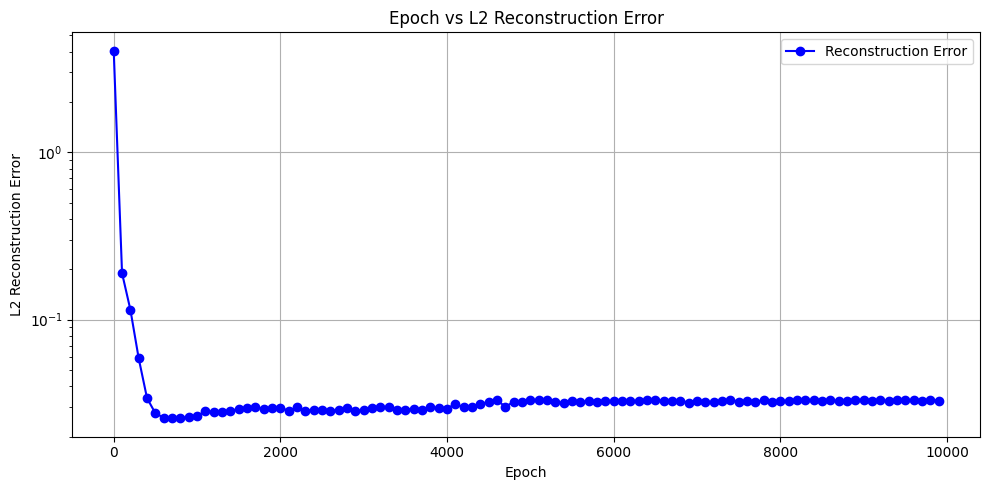

In [ ]:

dataset = training_data_pytorch
dataset.to('cuda')

# number of hidden units
nh = 15
# number of visible units
nv = 30

rbm15H = RBM(nv=nv,
          nh=nh,
          k=2,
          training='PCD',
          visible_normalized=True,
          lr=0.007,
          lr_trend='linear',
          bs=1000,
          epochs=10000,
          print_step=100,
          verbose=True,
          track_method=['rec_error'],
          track_learning=True,
          track_step = 100)

rbm15H.fit(dataset)
rbm15H.recPlot()
torch.save(rbm15H, "rbm15H_Final")

In [ ]:
with open('rbm15Hrecs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in rbm15H.rec_errors:
        writer.writerow([item])
    file.close()

with open('rbm15Hepochs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in rbm15H.usedEpochs:
        writer.writerow([item])
    file.close()

##20 Hidden Nodes

Dataset is on CPU. Memory pinning activated.
If the dataset is not too big, consider moving it to GPU calling dataset.to("cuda")
Epoch: 0, Loss: -1.301708459854126, Rec. error: 0.7078304123133421
rec_error = 3.6200068427772014
Epoch: 100, Loss: 0.013673782348632812, Rec. error: 0.16727492585778236
rec_error = 0.16518600753551163
Epoch: 200, Loss: -0.012347698211669922, Rec. error: 0.3620554357767105
rec_error = 0.09692348310698085
Epoch: 300, Loss: -0.21965312957763672, Rec. error: 0.45060979574918747
rec_error = 0.05139191514698596
Epoch: 400, Loss: 0.0827932357788086, Rec. error: 0.49726517498493195
rec_error = 0.03065854303163755
Epoch: 500, Loss: 0.10375452041625977, Rec. error: 0.5230743885040283
rec_error = 0.025131256485086007
Epoch: 600, Loss: -0.1804499626159668, Rec. error: 0.5604797005653381
rec_error = 0.02275989791712711
Epoch: 700, Loss: -0.5469379425048828, Rec. error: 0.5997408777475357
rec_error = 0.022609253695989703
Epoch: 800, Loss: -0.4190387725830078, Rec. error: 

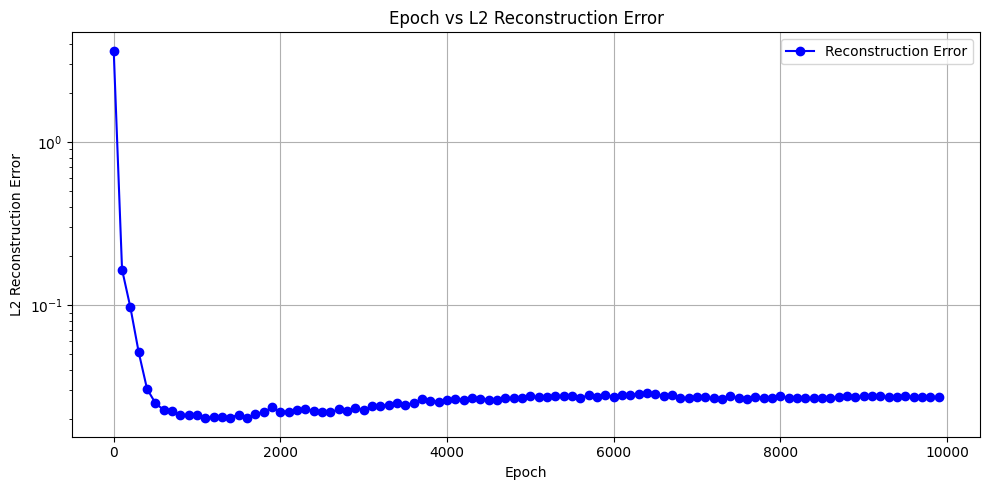

In [ ]:

dataset = training_data_pytorch
dataset.to('cuda')

# number of hidden units
nh = 20
# number of visible units
nv = 30

rbm20H = RBM(nv=nv,
          nh=nh,
          k=2,
          training='PCD',
          visible_normalized=True,
          lr=0.007,
          lr_trend='linear',
          bs=1000,
          epochs=10000,
          print_step=100,
          verbose=True,
          track_method=['rec_error'],
          track_learning=True,
          track_step = 100)

rbm20H.fit(dataset)
rbm20H.recPlot()
torch.save(rbm20H, "rbm20H_Final")

In [ ]:
with open('rbm20Hrecs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in rbm20H.rec_errors:
        writer.writerow([item])
    file.close()

with open('rbm20Hepochs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in rbm20H.usedEpochs:
        writer.writerow([item])
    file.close()

##25 Hidden Nodes

Dataset is on CPU. Memory pinning activated.
If the dataset is not too big, consider moving it to GPU calling dataset.to("cuda")
Epoch: 0, Loss: -1.6049752235412598, Rec. error: 0.7248760927468538
rec_error = 3.109099520269646
Epoch: 100, Loss: -0.005280017852783203, Rec. error: 0.19935062900185585
rec_error = 0.14658253230827248
Epoch: 200, Loss: 0.036341190338134766, Rec. error: 0.39421290904283524
rec_error = 0.09224105249003677
Epoch: 300, Loss: 0.04483842849731445, Rec. error: 0.43503210693597794
rec_error = 0.04601763798441368
Epoch: 400, Loss: -0.17015886306762695, Rec. error: 0.5239389687776566
rec_error = 0.029013279351512617
Epoch: 500, Loss: 0.08646535873413086, Rec. error: 0.5351385623216629
rec_error = 0.02417819347841324
Epoch: 600, Loss: -0.5634498596191406, Rec. error: 0.5992074757814407
rec_error = 0.023150752898965236
Epoch: 700, Loss: -0.34337425231933594, Rec. error: 0.5786397308111191
rec_error = 0.02086306143188492
Epoch: 800, Loss: 0.1752796173095703, Rec. error:

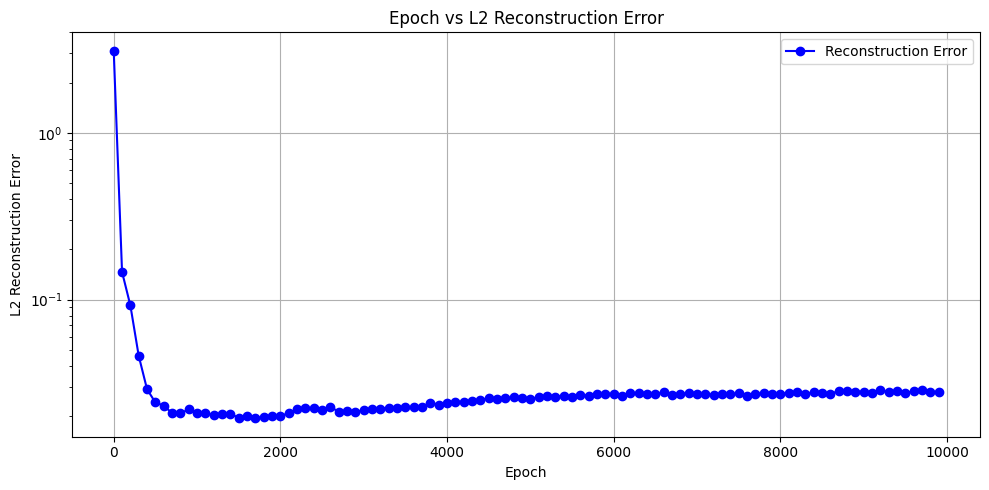

In [ ]:

dataset = training_data_pytorch
dataset.to('cuda')

# number of hidden units
nh = 25
# number of visible units
nv = 30

rbm25H = RBM(nv=nv,
          nh=nh,
          k=2,
          training='PCD',
          visible_normalized=True,
          lr=0.007,
          lr_trend='linear',
          bs=1000,
          epochs=10000,
          print_step=100,
          verbose=True,
          track_method=['rec_error'],
          track_learning=True,
          track_step = 100)

rbm25H.fit(dataset)
rbm25H.recPlot()
torch.save(rbm25H, "rbm25H_Final")

In [ ]:
with open('rbm25Hrecs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in rbm25H.rec_errors:
        writer.writerow([item])
    file.close()

with open('rbm25Hepochs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in rbm25H.usedEpochs:
        writer.writerow([item])
    file.close()

#Implementing the Quantum Boltzmann Machine

References:

https://arxiv.org/pdf/1601.02036

https://arxiv.org/pdf/2001.08997

https://pennylane.ai/qml/demos/tutorial_fermionic_operators

In [8]:
!pip install pennylane-lightning[gpu]
!pip install --upgrade pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 24.0 MB/s eta 0:00:00


In [9]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import torch
import numpy as np
import pennylane as qml
import torch.nn as nn

class sqRBM:
    def __init__(
        self, num_visible, num_hidden,
        lr=1e-3, k=10,
        epochs=100, gamma=0.99,
        sigma=1e-4, batch_size=300,
        weight_decay=1e-4
    ):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.lr = lr
        self.k = k
        self.gamma = gamma
        self.epochs = epochs
        self.sigma = sigma
        self.batch_size = batch_size

        self.usedEpochs = []
        self.rec_errors = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Using device:", self.device)

        std = np.sqrt(2.0 / (num_visible + num_hidden))
        self.w = torch.randn(num_visible, num_hidden, device=self.device) * std
        self.b = torch.zeros(num_visible, device=self.device)
        self.c = torch.zeros(num_hidden, device=self.device)

        self.fantasy = torch.randn(batch_size, num_visible, device=self.device)

        try:
            self.dev = qml.device("lightning.gpu", wires=num_hidden)
        except:
            self.dev = qml.device("default.qubit", wires=num_hidden)
            print("Falling back to default.qubit (CPU)")

        @qml.qnode(self.dev, interface="torch", diff_method="adjoint")
        def circuit(v, w, c):
            angles = torch.matmul(v, w) + c
            angles = 2.0 * angles  # Optional scaling
            for _ in range(2):
                for i in range(num_hidden):
                    qml.RY(angles[i], wires=i)
                    qml.RZ(angles[i], wires=i)
                for i in range(num_hidden - 1):
                    qml.CNOT(wires=[i, i + 1])
                if num_hidden > 1:
                    qml.CNOT(wires=[num_hidden - 1, 0])
            return [qml.expval(qml.PauliZ(i)) for i in range(num_hidden)]

        self.circuit = circuit

        self.opt = torch.optim.Adam([self.w, self.b, self.c], lr=lr, weight_decay=weight_decay)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.opt, gamma=gamma)

    def forward(self, v_batch: torch.Tensor) -> torch.Tensor:
        v_batch = v_batch.to(self.device).float()
        tapes = []

        for v in v_batch:
            v = v.detach().cpu()
            w = self.w.detach().cpu()
            c = self.c.detach().cpu()
            with qml.tape.QuantumTape() as tape:
                angles = torch.matmul(v, w) + c
                angles = 2.0 * angles
                for _ in range(2):
                    for i in range(self.num_hidden):
                        qml.RY(angles[i], wires=i)
                        qml.RZ(angles[i], wires=i)
                    for i in range(self.num_hidden - 1):
                        qml.CNOT(wires=[i, i + 1])
                    if self.num_hidden > 1:
                        qml.CNOT(wires=[self.num_hidden - 1, 0])
                for i in range(self.num_hidden):
                    qml.expval(qml.PauliZ(i))
            tapes.append(tape)

        results = qml.execute(tapes, device=self.dev, interface="torch")
        results = [torch.tensor(r, dtype=torch.float32) for r in results]
        return torch.sigmoid(torch.stack(results).to(self.device))

    def sample_visible(self, h_prob: torch.Tensor) -> torch.Tensor:
        h_prob = h_prob.to(self.device)
        mean = torch.matmul(h_prob, self.w.T) + self.b
        return mean + self.sigma * torch.randn_like(mean)

    def fit(self, data: torch.Tensor, epochs: int = None):
        if epochs is None:
            epochs = self.epochs

        data = data.clone().detach().float().to(self.device)
        n = data.shape[0]

        best_error = float('inf')
        best_w = self.w.clone()
        best_b = self.b.clone()
        best_c = self.c.clone()

        for epoch in range(epochs):
            perm = torch.randperm(n, device=self.device)
            data_shuf = data[perm][:900]
            epoch_err = 0.0
            counter = 0

            for i in range(0, len(data_shuf), self.batch_size):
                v0 = data_shuf[i : i + self.batch_size]
                if v0.size(0) < self.batch_size:
                    break

                h0 = self.forward(v0)
                hk = h0
                for _ in range(self.k):
                    vk = self.sample_visible(hk)
                    hk = self.forward(vk)

                pos = torch.matmul(v0.T, h0)
                neg = torch.matmul(vk.T, hk)

                self.opt.zero_grad()
                self.w.grad = -(pos - neg - 0.001 * self.w)
                self.b.grad = -torch.sum(v0 - vk, dim=0)
                self.c.grad = -torch.sum(h0 - hk, dim=0)
                self.opt.step()

                self.scheduler.step()
                epoch_err += torch.sum((v0 - vk) ** 2).item() / 900

            if epoch_err <= best_error:
                best_error = epoch_err
                best_w = self.w.clone()
                best_b = self.b.clone()
                best_c = self.c.clone()
            else:
                with torch.no_grad():
                    self.w.copy_(best_w)
                    self.b.copy_(best_b)
                    self.c.copy_(best_c)

            self.rec_errors.append(best_error)
            self.usedEpochs.append(epoch)
            print(f"Epoch {epoch}/{epochs} — Error: {epoch_err:.6f} (Best: {best_error:.6f})")

    def recPlot(self):
        import matplotlib.pyplot as plt
        plt.plot(self.usedEpochs, self.rec_errors, marker='o')
        plt.yscale('log')
        plt.xlabel('Epoch')
        plt.ylabel('L2 Reconstruction Error')
        plt.title('Reconstruction Error Over Time')
        plt.grid(True)
        plt.show()


##5 Hidden Nodes

In [ ]:
sqRBM5H = sqRBM(30, 5)
training_data_pytorch = training_data_pytorch.cpu()
sqRBM5H.fit(training_data_pytorch)

Using device: cpu
Falling back to default.qubit (CPU)
Epoch 0/100 — Error: 2.627175 (Best: 2.627175)
Epoch 1/100 — Error: 2.501757 (Best: 2.501757)
Epoch 2/100 — Error: 2.422246 (Best: 2.422246)
Epoch 3/100 — Error: 2.340635 (Best: 2.340635)
Epoch 4/100 — Error: 2.266552 (Best: 2.266552)
Epoch 5/100 — Error: 2.147438 (Best: 2.147438)
Epoch 6/100 — Error: 2.053062 (Best: 2.053062)
Epoch 7/100 — Error: 1.955267 (Best: 1.955267)
Epoch 8/100 — Error: 1.864763 (Best: 1.864763)
Epoch 9/100 — Error: 1.784171 (Best: 1.784171)
Epoch 10/100 — Error: 1.697412 (Best: 1.697412)
Epoch 11/100 — Error: 1.666873 (Best: 1.666873)
Epoch 12/100 — Error: 1.593987 (Best: 1.593987)
Epoch 13/100 — Error: 1.563350 (Best: 1.563350)
Epoch 14/100 — Error: 1.507245 (Best: 1.507245)
Epoch 15/100 — Error: 1.485435 (Best: 1.485435)
Epoch 16/100 — Error: 1.443323 (Best: 1.443323)
Epoch 17/100 — Error: 1.428498 (Best: 1.428498)
Epoch 18/100 — Error: 1.394155 (Best: 1.394155)
Epoch 19/100 — Error: 1.337782 (Best: 1.3377

In [ ]:
torch.save(sqRBM5H, "sqRBM5H_Final")
sqRBM5H.recPlot()

AttributeError: Can't pickle local object 'sqRBM.__init__.<locals>.circuit'

In [ ]:
with open('sqRBM5Hrecs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in sqRBM5H.rec_errors:
        writer.writerow([item])
    file.close()

with open('sqRBM5Hepochs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in sqRBM5H.usedEpochs:
        writer.writerow([item])
    file.close()

##10 Hidden Nodes

In [13]:
sqRBM10H = sqRBM(30, 10)
training_data_pytorch = training_data_pytorch.cpu()
sqRBM10H.fit(training_data_pytorch)

Using device: cuda
Epoch 0/100 — Error: 4.249762 (Best: 4.249762)
Epoch 1/100 — Error: 4.004793 (Best: 4.004793)
Epoch 2/100 — Error: 3.781910 (Best: 3.781910)
Epoch 3/100 — Error: 3.574552 (Best: 3.574552)
Epoch 4/100 — Error: 3.349096 (Best: 3.349096)
Epoch 5/100 — Error: 3.188615 (Best: 3.188615)
Epoch 6/100 — Error: 3.031214 (Best: 3.031214)
Epoch 7/100 — Error: 2.855516 (Best: 2.855516)
Epoch 8/100 — Error: 2.731854 (Best: 2.731854)
Epoch 9/100 — Error: 2.586789 (Best: 2.586789)
Epoch 10/100 — Error: 2.472288 (Best: 2.472288)
Epoch 11/100 — Error: 2.368397 (Best: 2.368397)
Epoch 12/100 — Error: 2.271512 (Best: 2.271512)
Epoch 13/100 — Error: 2.171480 (Best: 2.171480)
Epoch 14/100 — Error: 2.062277 (Best: 2.062277)
Epoch 15/100 — Error: 1.967811 (Best: 1.967811)
Epoch 16/100 — Error: 1.905631 (Best: 1.905631)
Epoch 17/100 — Error: 1.837009 (Best: 1.837009)
Epoch 18/100 — Error: 1.758999 (Best: 1.758999)
Epoch 19/100 — Error: 1.680473 (Best: 1.680473)
Epoch 20/100 — Error: 1.627985 

In [ ]:
torch.save(sqRBM10H, "sqRBM10H_Final")
sqRBM10H.recPlot()

In [14]:
with open('sqRBM10Hrecs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in sqRBM10H.rec_errors:
        writer.writerow([item])
    file.close()

with open('sqRBM10Hepochs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in sqRBM10H.usedEpochs:
        writer.writerow([item])
    file.close()

##15 Hidden Nodes

In [10]:
sqRBM15H = sqRBM(30, 15)
sqRBM15H.fit(training_data_pytorch)

Using device: cuda
Epoch 0/100 — Error: 3.838354 (Best: 3.838354)
Epoch 1/100 — Error: 3.486980 (Best: 3.486980)
Epoch 2/100 — Error: 3.130891 (Best: 3.130891)
Epoch 3/100 — Error: 2.790966 (Best: 2.790966)
Epoch 4/100 — Error: 2.495098 (Best: 2.495098)
Epoch 5/100 — Error: 2.218580 (Best: 2.218580)
Epoch 6/100 — Error: 1.967056 (Best: 1.967056)
Epoch 7/100 — Error: 1.779104 (Best: 1.779104)
Epoch 8/100 — Error: 1.609865 (Best: 1.609865)
Epoch 9/100 — Error: 1.472764 (Best: 1.472764)
Epoch 10/100 — Error: 1.346299 (Best: 1.346299)
Epoch 11/100 — Error: 1.255380 (Best: 1.255380)
Epoch 12/100 — Error: 1.165993 (Best: 1.165993)
Epoch 13/100 — Error: 1.089747 (Best: 1.089747)
Epoch 14/100 — Error: 1.025869 (Best: 1.025869)
Epoch 15/100 — Error: 0.967276 (Best: 0.967276)
Epoch 16/100 — Error: 0.886112 (Best: 0.886112)
Epoch 17/100 — Error: 0.857341 (Best: 0.857341)
Epoch 18/100 — Error: 0.792932 (Best: 0.792932)
Epoch 19/100 — Error: 0.770720 (Best: 0.770720)
Epoch 20/100 — Error: 0.727250 

In [11]:
torch.save(sqRBM15H, "sqRBM15H_Final")
sqRBM15H.recPlot()

TypeError: cannot pickle 'pennylane_lightning.lightning_gpu_ops.StateVectorC128' object

In [12]:
with open('sqRBM15Hrecs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in sqRBM15H.rec_errors:
        writer.writerow([item])
    file.close()

with open('sqRBM15Hepochs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in sqRBM15H.usedEpochs:
        writer.writerow([item])
    file.close()

##20 Hidden Nodes

In [ ]:
sqRBM20H = sqRBM(30, 20)
sqRBM20H.fit(training_data_pytorch)

In [ ]:
torch.save(sqRBM20H, "sqRBM20H_Final")
sqRBM20H.recPlot()

In [ ]:
with open('sqRBM20Hrecs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in sqRBM20H.rec_errors:
        writer.writerow([item])
    file.close()

with open('sqRBM20Hepochs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in sqRBM20H.usedEpochs:
        writer.writerow([item])
    file.close()

##25 Hidden Nodes

In [ ]:
sqRBM25H = sqRBM(30, 25)
training_data_pytorch = training_data_pytorch.cpu()
sqRBM25H.fit(training_data_pytorch)

Using device: cpu
Falling back to default.qubit (CPU)


KeyboardInterrupt: 

In [ ]:
torch.save(sqRBM25H, "sqRBM25H_Final")
sqRBM25H.recPlot()

In [ ]:
with open('sqRBM25Hrecs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in sqRBM25H.rec_errors:
        writer.writerow([item])
    file.close()

with open('sqRBM25Hepochs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in sqRBM25H.usedEpochs:
        writer.writerow([item])
    file.close()

#Analysis of Model Performance

##Classical Model Scaling

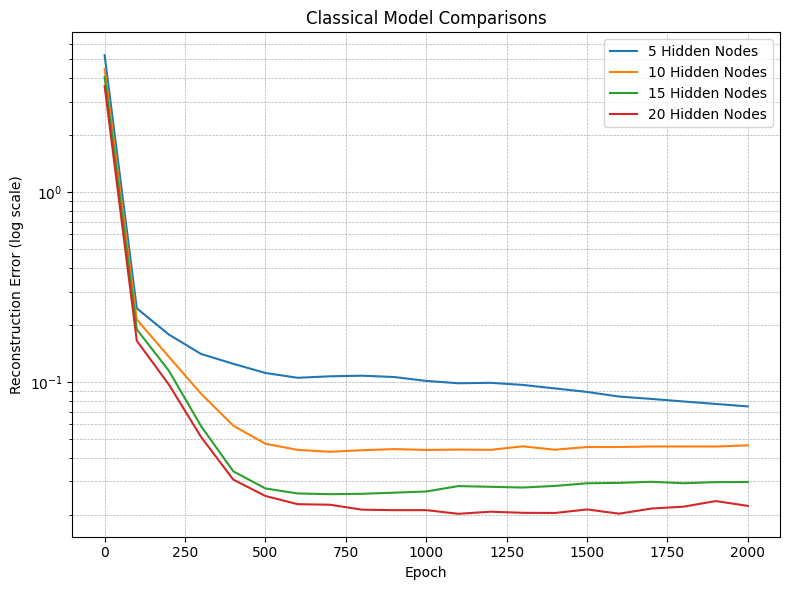

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(rbmepochs, rbm5Hrec_errors, label='5 Hidden Nodes')
plt.plot(rbmepochs, rbm10Hrec_errors, label='10 Hidden Nodes')
plt.plot(rbmepochs, rbm15Hrec_errors, label='15 Hidden Nodes')
plt.plot(rbmepochs, rbm20Hrec_errors, label='20 Hidden Nodes')

plt.yscale('log')

plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error (log scale)")
plt.title("Classical Model Comparisons")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

##Quantum Model Scaling

In [6]:
from google.colab import files
upload = files.upload()

Saving best_errors_extended.csv to best_errors_extended (1).csv


In [25]:
# Replace 'filename.csv' with your actual file name
filename = 'rbm20Hrecs.csv'

# Initialize an empty list
rbm20Hrec_errors = []

# Open and read the file
with open(filename, 'r') as file:
    for line in file:
        # Strip whitespace and convert to float (or int, if preferred)
        stripped = line.strip()
        if stripped:  # skip empty lines
            rbm20Hrec_errors.append(float(stripped))
rbm20Hrec_errors = rbm20Hrec_errors[:21]
# Print the resulting list
print("Extracted numbers:", rbm20Hrec_errors)


Extracted numbers: [3.6200068427772014, 0.16518600753551163, 0.09692348310698085, 0.05139191514698596, 0.03065854303163755, 0.025131256485086007, 0.02275989791712711, 0.022609253695989703, 0.021292648046086726, 0.02116173692174851, 0.021174279884291457, 0.020253227262864285, 0.02077305511577192, 0.02049591573588623, 0.020453369896050292, 0.02135067042256042, 0.020283708461172462, 0.02158453863396987, 0.022078487559073802, 0.023633073360241032, 0.022293139511234843]


In [42]:
print(sqRBM20Hrec_errors)
print(sqRBM15Hrec_errors)
print(sqRBM10Hrec_errors)
print(sqRBM5Hrec_errors)
print(sqRBMepochs)
print(rbmepochs)
sqRBMepochs = [i for i in range(100)]
print(sqRBMepochs)

[8.979452, 8.18392, 7.487956, 6.88189, 6.41386, 5.926703, 5.494952, 5.166403, 4.83224, 4.460465, 4.235949, 3.857626, 3.694321, 3.42549, 3.20059, 3.089749, 2.827737, 2.708679, 2.583499, 2.473018, 2.374671, 2.264913, 2.172324, 2.084881, 2.001802, 1.963362, 1.87656, 1.80905, 1.723107, 1.719531, 1.637692, 1.625249, 1.525311, 1.520443, 1.47754, 1.439032, 1.432708, 1.375291, 1.341443, 1.341443, 1.336586, 1.322753, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.24778, 1.241473, 1.241473, 1.241473, 1.238931, 1.238931, 1.238931, 1.238931, 1.220272, 1.21836, 1.20628, 1.20628, 1.20628, 1.200514, 1.19431, 1.19431, 1.19431, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123, 1.16123]
[3.838353814019097, 3.4869798448350693, 3.1308911132812502, 2.7909

100 100


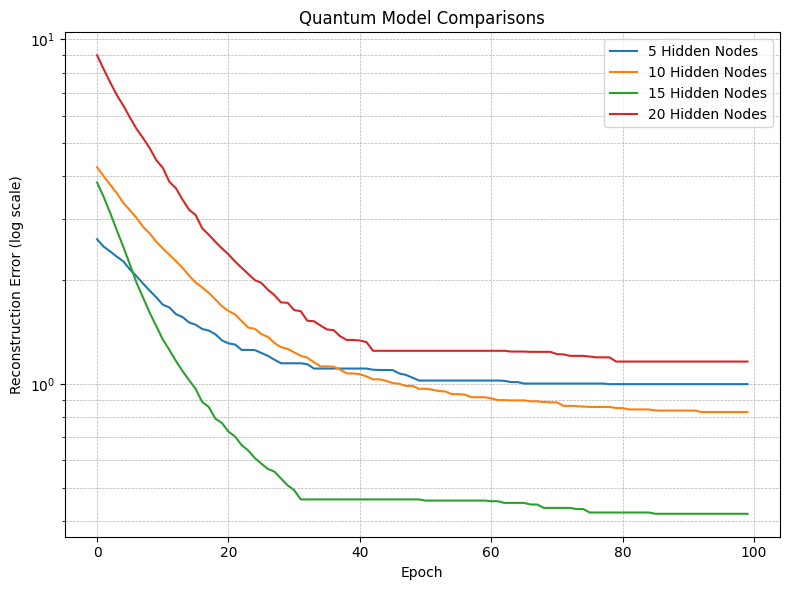

In [43]:
print(len(sqRBMepochs),len(sqRBM5Hrec_errors))
sqRBM20Hrec_errors.append(1.16123)
plt.figure(figsize=(8, 6))
plt.plot(sqRBMepochs, sqRBM5Hrec_errors, label='5 Hidden Nodes')
plt.plot(sqRBMepochs, sqRBM10Hrec_errors, label='10 Hidden Nodes')
plt.plot(sqRBMepochs, sqRBM15Hrec_errors, label='15 Hidden Nodes')
plt.plot(sqRBMepochs, sqRBM20Hrec_errors, label='20 Hidden Nodes')

plt.yscale('log')

plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error (log scale)")
plt.title("Quantum Model Comparisons")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

##Classical Quantum Comparisons

###5 Hidden Nodes

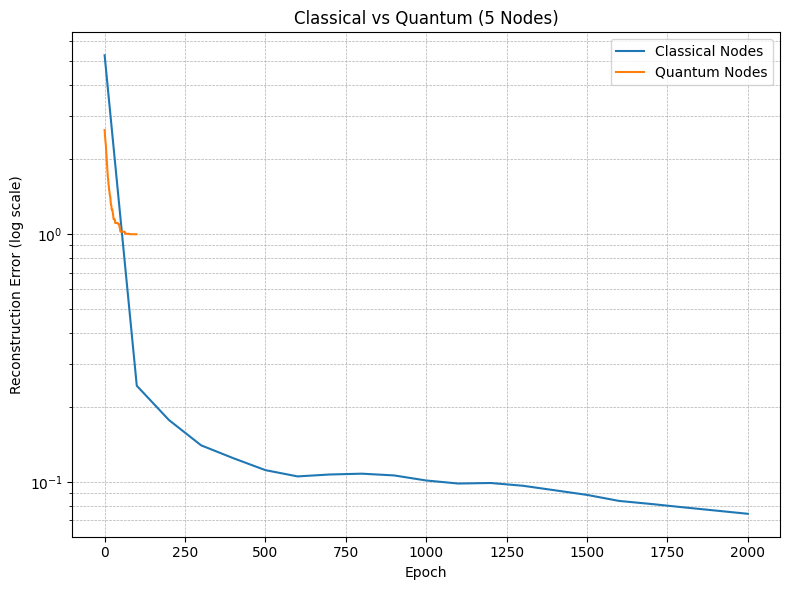

In [45]:
plt.figure(figsize=(8, 6))
plt.plot(rbmepochs, rbm5Hrec_errors, label='Classical Nodes')
plt.plot(sqRBMepochs, sqRBM5Hrec_errors, label='Quantum Nodes')

plt.yscale('log')

plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error (log scale)")
plt.title("Classical vs Quantum (5 Nodes)")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

###10 Hidden Nodes

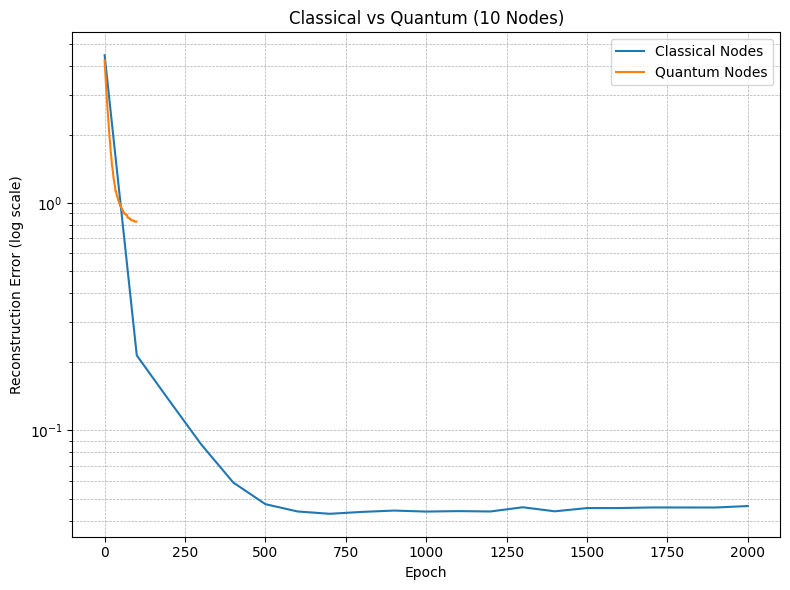

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(rbmepochs, rbm10Hrec_errors, label='Classical Nodes')
plt.plot(sqRBMepochs, sqRBM10Hrec_errors, label='Quantum Nodes')

plt.yscale('log')

plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error (log scale)")
plt.title("Classical vs Quantum (10 Nodes)")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

###15 Hidden Nodes

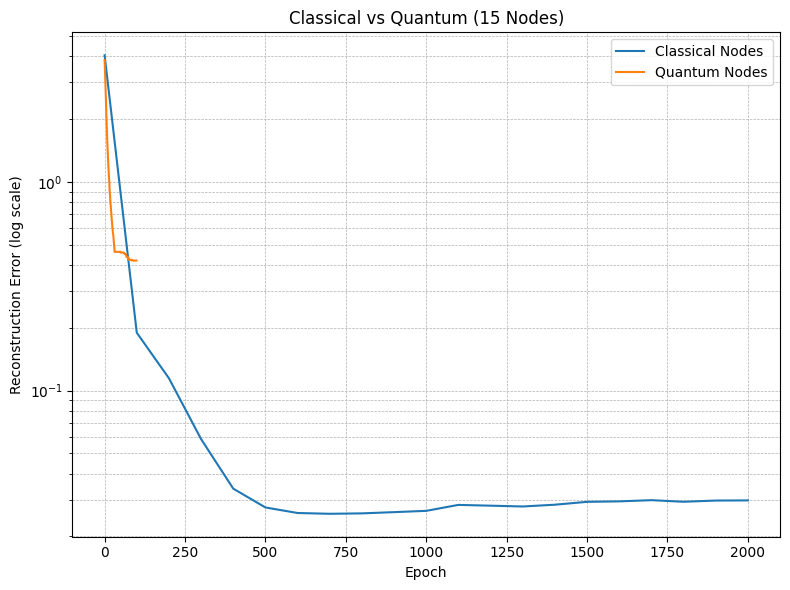

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(rbmepochs, rbm15Hrec_errors, label='Classical Nodes')
plt.plot(sqRBMepochs, sqRBM15Hrec_errors, label='Quantum Nodes')

plt.yscale('log')

plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error (log scale)")
plt.title("Classical vs Quantum (15 Nodes)")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

###20 Hidden Nodes

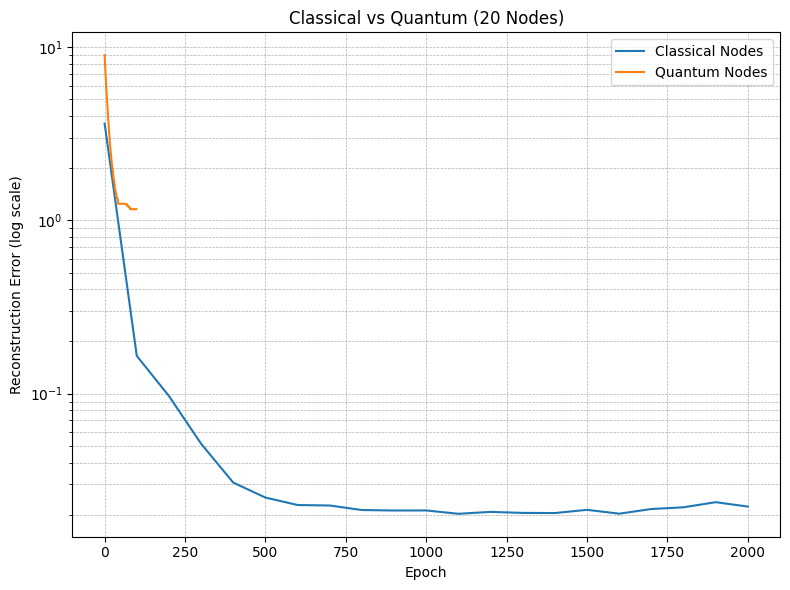

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(rbmepochs, rbm20Hrec_errors, label='Classical Nodes')
plt.plot(sqRBMepochs, sqRBM20Hrec_errors, label='Quantum Nodes')

plt.yscale('log')

plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error (log scale)")
plt.title("Classical vs Quantum (20 Nodes)")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

###25 Hidden Nodes

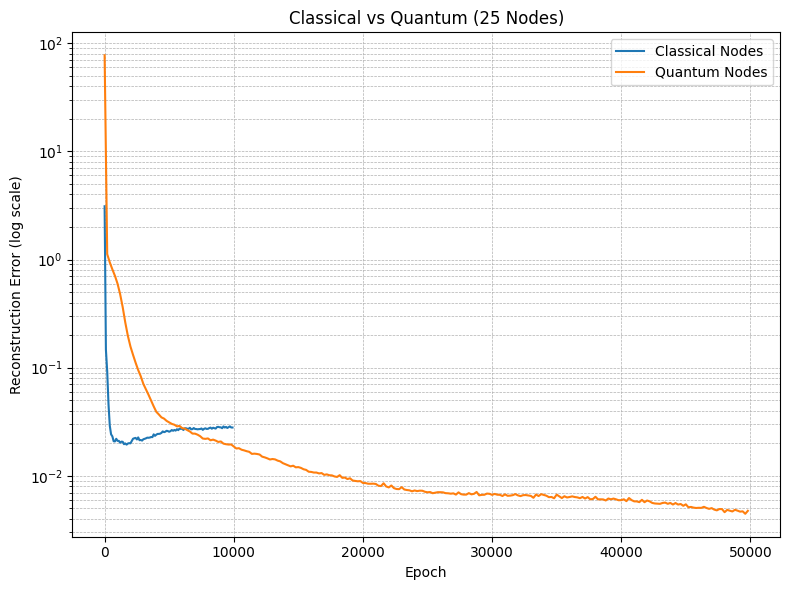

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(rbm25H.usedEpochs, rbm25H.rec_errors, label='Classical Nodes')
plt.plot(sqRBM25H.usedEpochs, sqRBM25H.rec_errors, label='Quantum Nodes')

plt.yscale('log')

plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error (log scale)")
plt.title("Classical vs Quantum (25 Nodes)")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()